In [334]:
import pandas as pd
import numpy as np
import cv2
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, ZeroPadding2D,  Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy

from sklearn.metrics import classification_report, confusion_matrix

import numpy.random as rng
import random
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

import config
import CustomDataGenerator
import model

In [335]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [2]:
EPOCHS = config.EPOCHS
BATCH_SIZE = config.BATCH_SIZE
VAL_BATCH_SIZE = config.VAL_BATCH_SIZE
TARGET_SIZE = config.TARGET_SIZE
INPUT_SIZE = config.INPUT_SIZE
NUM_CLASSES = config.NUM_CLASSES
LEARNING_RATE = config.LEARNING_RATE
CLASSES = config.CLASSES


In [8]:
train_csv = './dataset/train_data.csv'
test_csv = './dataset/test_data.csv'

In [9]:
train_df = pd.read_csv(train_csv, encoding='utf-8')
test_df = pd.read_csv(test_csv, encoding='utf-8')

In [11]:
#train_df.drop('Unnamed: 0', axis=1, inplace=True)
#test_df.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
columns = ["image1", "image2", "label"]
train_df.columns = columns
test_df.columns = columns

In [13]:
train_df.head()

,image1,image2,label
0,/Users/egeoguzman/Desktop/Liveness-Detection/d...,/Users/egeoguzman/Desktop/Liveness-Detection/d...,1
1,/Users/egeoguzman/Desktop/Liveness-Detection/d...,/Users/egeoguzman/Desktop/Liveness-Detection/d...,0
2,/Users/egeoguzman/Desktop/Liveness-Detection/d...,/Users/egeoguzman/Desktop/Liveness-Detection/d...,0
3,/Users/egeoguzman/Desktop/Liveness-Detection/d...,/Users/egeoguzman/Desktop/Liveness-Detection/d...,0
4,/Users/egeoguzman/Desktop/Liveness-Detection/d...,/Users/egeoguzman/Desktop/Liveness-Detection/d...,0


In [14]:
test_df.head()

,image1,image2,label
0,/Users/egeoguzman/Desktop/Liveness-Detection/d...,/Users/egeoguzman/Desktop/Liveness-Detection/d...,0
1,/Users/egeoguzman/Desktop/Liveness-Detection/d...,/Users/egeoguzman/Desktop/Liveness-Detection/d...,0
2,/Users/egeoguzman/Desktop/Liveness-Detection/d...,/Users/egeoguzman/Desktop/Liveness-Detection/d...,0
3,/Users/egeoguzman/Desktop/Liveness-Detection/d...,/Users/egeoguzman/Desktop/Liveness-Detection/d...,0
4,/Users/egeoguzman/Desktop/Liveness-Detection/d...,/Users/egeoguzman/Desktop/Liveness-Detection/d...,1


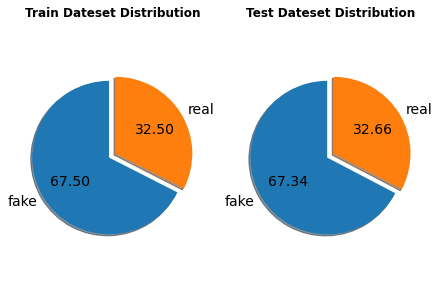

In [15]:
fig1, (ax1,ax2) = plt.subplots(1,2, constrained_layout=True)
ax1.pie([train_df['label'].value_counts()[0], train_df['label'].value_counts()[1]],
        labels=["fake", "real"],
        autopct = '%.2f',
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14},
        explode=(0.1,0)
         )
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Train Dateset Distribution', fontweight='bold')
ax2.pie([test_df['label'].value_counts()[0], test_df['label'].value_counts()[1]],
        labels=["fake", "real"],
        autopct = '%.2f',
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14},
        explode=(0.1,0)
         )
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Test Dateset Distribution', fontweight='bold')
plt.show()

Text(0.5, 0.98, 'Real - Real Pair (Label:1)')

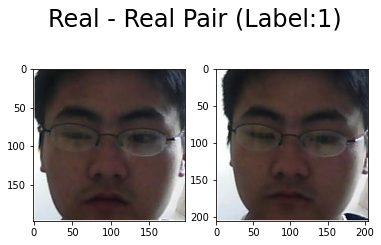

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
img1 = plt.imread(train_df.image1[0])
ax1.imshow(img1)
ax2 = fig.add_subplot(1,2,2)
img2 = plt.imread(train_df.image2[0])
ax2.imshow(img2)
fig.suptitle('Real - Real Pair (Label:1)', fontsize=24)

Text(0.5, 0.98, 'Real - Fake Pair (Label:0)')

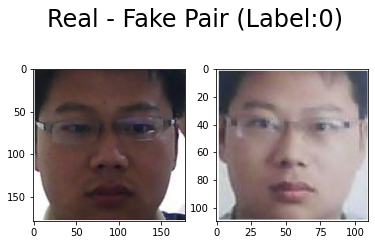

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
img1 = plt.imread(train_df.image1[1])
ax1.imshow(img1)
ax2 = fig.add_subplot(1,2,2)
img2 = plt.imread(train_df.image2[1])
ax2.imshow(img2)
fig.suptitle('Real - Fake Pair (Label:0)', fontsize=24)

In [18]:
traingen = CustomDataGenerator.CustomDataGen(train_df,
                      X_col={'img1_path':'image1', 'img2_path': 'image2'},
                      y_col={'labels': 'label'},
                      batch_size=BATCH_SIZE, input_size=TARGET_SIZE, shuffle=True)

valgen = CustomDataGenerator.CustomDataGen(test_df,
                       X_col={'img1_path':'image1', 'img2_path': 'image2'},
                       y_col={'labels': 'label'},
                       batch_size=BATCH_SIZE, input_size=TARGET_SIZE, shuffle=True)

In [236]:
pair, label = valgen[0]
print(pair[0].shape)
print(pair[1].shape)
print(label.shape)
print(len(valgen))

(128, 64, 64, 3)
(128, 64, 64, 3)
(128,)
106


(128, 64, 64, 3)
(128, 64, 64, 3)
(128,)


Text(0.5, 0.98, 'Label:0.0')

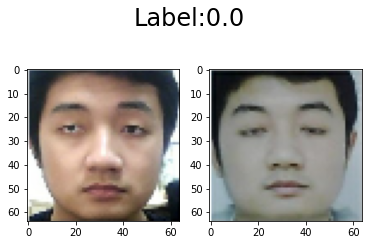

In [110]:
pair, label = traingen[70]
print(pair[0].shape)
print(pair[1].shape)
print(label.shape)
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
#img1 = plt.imread(img1[0])
ax1.imshow(pair[0][0,:,:,:]*255.)
ax2 = fig.add_subplot(1,2,2)
#img2 = plt.imread(img2[0])
ax2.imshow(pair[1][0,:,:,:]*255.)
fig.suptitle(f'Label:{label[0]}', fontsize=24)

In [35]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x-y), axis=1, keepdims=True))

def eucl_distance_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred, margin=1):
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [36]:
base_network = model.Siamese((64,64,3))

input_a = Input(shape=(64,64,3))
input_b = Input(shape=(64,64,3))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_distance_shape)([processed_a, processed_b])
#prediction = Dense(1,activation='sigmoid',bias_initializer=model.initialize_bias)(distance)

siamese_model = Model(inputs=[input_a,input_b], outputs=distance)
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 240)          6650796     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

In [28]:
rms = tf.keras.optimizers.RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
siamese_model.compile(loss=contrastive_loss, optimizer=rms)

In [29]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
   # ModelCheckpoint('/content/Liveness-Detection/checkpoints/siamese.h5', verbose=1, save_weights_only=True)
]

In [32]:
H = siamese_model.fit(traingen,
          steps_per_epoch = len(train_df)//BATCH_SIZE,
          validation_data=valgen,
          validation_steps = len(test_df)//BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=callbacks,
          verbose= 1)

Epoch 1/20
427/427 [==============================] - 403s 863ms/step - loss: 0.2219 - val_loss: 0.0754
Epoch 2/20
427/427 [==============================] - 369s 864ms/step - loss: 0.0609 - val_loss: 0.0405
Epoch 3/20
427/427 [==============================] - 367s 859ms/step - loss: 0.0313 - val_loss: 0.0220
Epoch 4/20
427/427 [==============================] - 368s 863ms/step - loss: 0.0232 - val_loss: 0.0231
Epoch 5/20
427/427 [==============================] - 366s 858ms/step - loss: 0.0162 - val_loss: 0.0166
Epoch 6/20
427/427 [==============================] - 366s 856ms/step - loss: 0.0134 - val_loss: 0.0097
Epoch 7/20
427/427 [==============================] - 365s 855ms/step - loss: 0.0122 - val_loss: 0.0079
Epoch 8/20
427/427 [==============================] - 366s 857ms/step - loss: 0.0091 - val_loss: 0.0064
Epoch 9/20
427/427 [==============================] - 364s 853ms/step - loss: 0.0078 - val_loss: 0.0058
Epoch 10/20
427/427 [==============================] - 364s 853m

In [38]:
siamese_model.save("./models/siamese/siamese.h5")

In [42]:
siamese_model.load_weights("./models/siamese/siamese.h5")
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 240)          6650796     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

In [45]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [263]:
valgen_test = CustomDataGenerator.CustomDataGen(test_df,
                       X_col={'img1_path':'image1', 'img2_path': 'image2'},
                       y_col={'labels': 'label'},
                       batch_size=1, input_size=TARGET_SIZE, shuffle=True)

In [265]:
pred, tr_y = [], []
val_gen = iter(valgen_test)
for i in tqdm(range(len(test_df))):
    (img1, img2), label = next(val_gen)
    tr_y.append(label)
    pred.append(siamese_model.predict([img1, img2])[0][0])

100%|██████████| 13695/13695 [27:44<00:00,  8.23it/s] 


In [266]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(1.0, 0.19)

In [305]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    valgen_idx = random.randint(0, len(valgen_test))
    test_point, test_label = valgen_test[valgen_idx]
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1)*255., cmap='gray')
    ax2.imshow(np.squeeze(img2)*255., cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = siamese_model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Face")
    else:
        print("Its a Genuine Face")

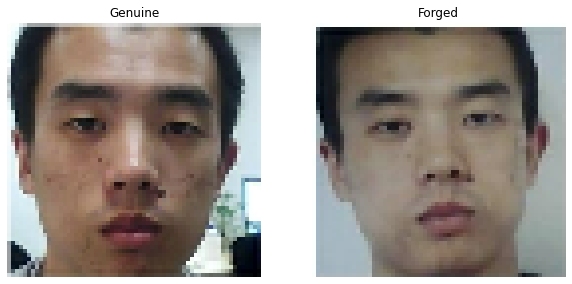

Difference Score =  2.4530911
Its a Forged Face


In [314]:
predict_score()

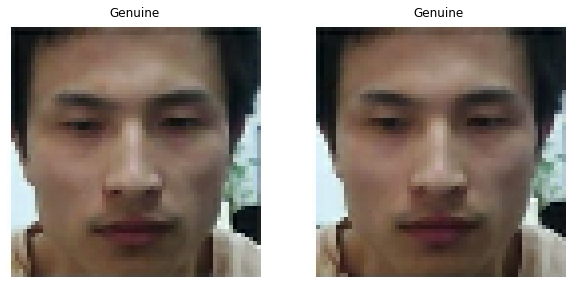

Difference Score =  0.0
Its a Genuine Face


In [315]:
predict_score()

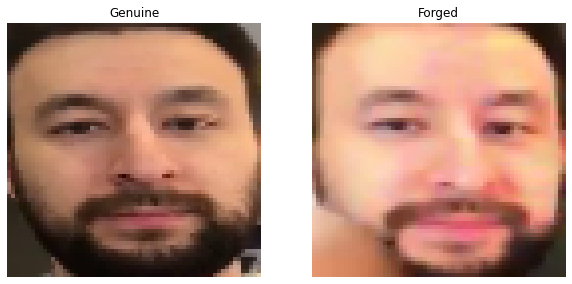

Difference Score =  0.87616223
Its a Forged Face


In [316]:
predict_score()

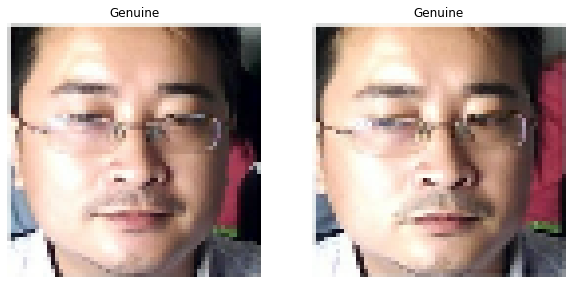

Difference Score =  0.0
Its a Genuine Face


In [317]:
predict_score()

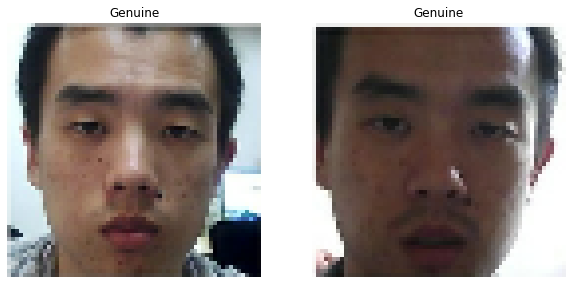

Difference Score =  0.0
Its a Genuine Face


In [318]:
predict_score()

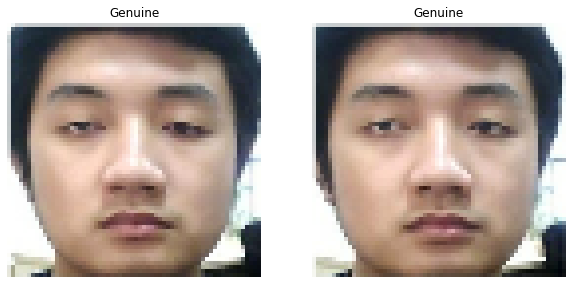

Difference Score =  0.0
Its a Genuine Face


In [319]:
predict_score()

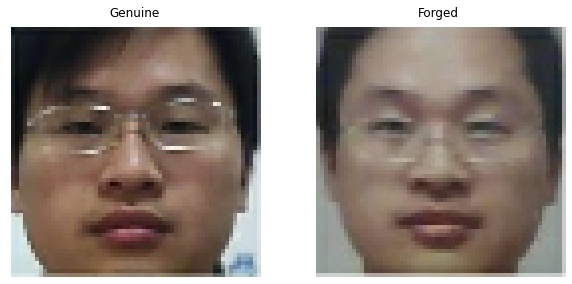

Difference Score =  2.1189911
Its a Forged Face


In [320]:
predict_score()

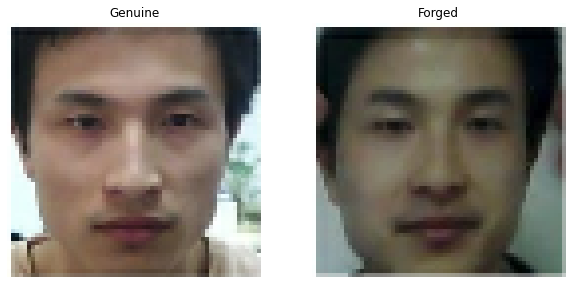

Difference Score =  2.5318499
Its a Forged Face


In [321]:
predict_score()

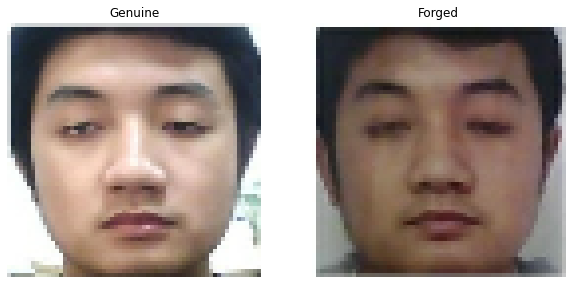

Difference Score =  2.1843727
Its a Forged Face


In [322]:
predict_score()

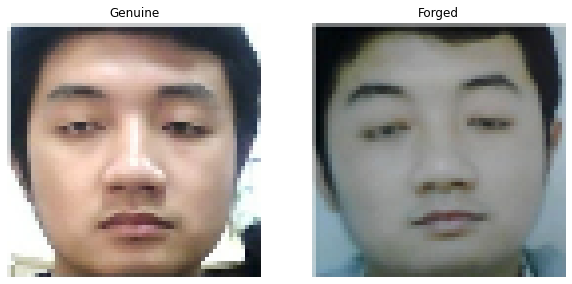

Difference Score =  2.987505
Its a Forged Face


In [323]:
predict_score()

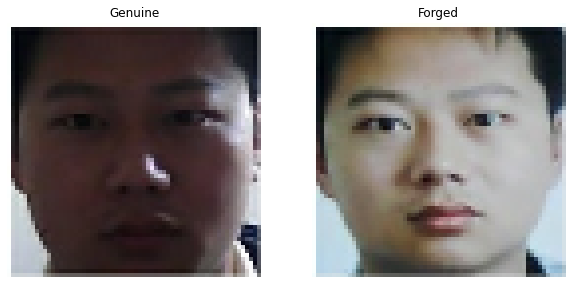

Difference Score =  3.8299067
Its a Forged Face


In [324]:
predict_score()

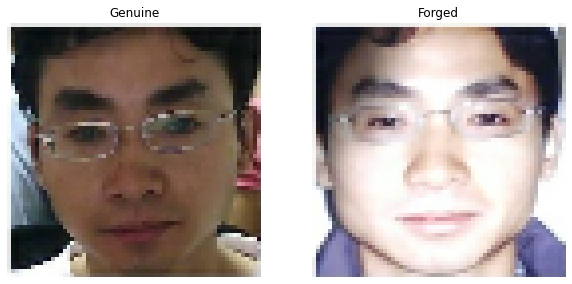

Difference Score =  2.1565447
Its a Forged Face


In [325]:
predict_score()

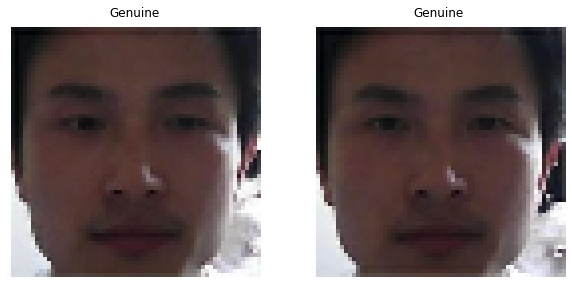

Difference Score =  0.0
Its a Genuine Face


In [326]:
predict_score()

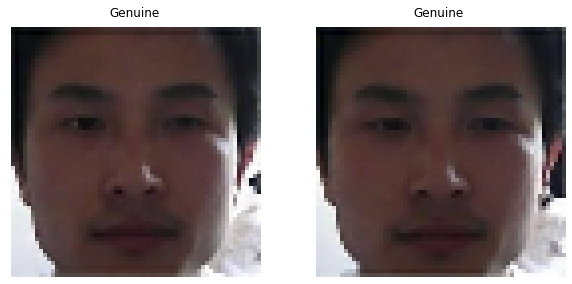

Difference Score =  0.0
Its a Genuine Face


In [327]:
predict_score()

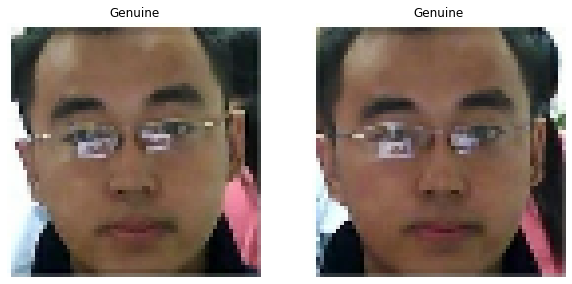

Difference Score =  0.0
Its a Genuine Face


In [328]:
predict_score()

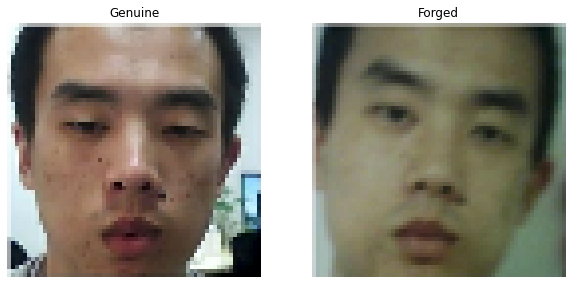

Difference Score =  2.3858426
Its a Forged Face


In [329]:
predict_score()

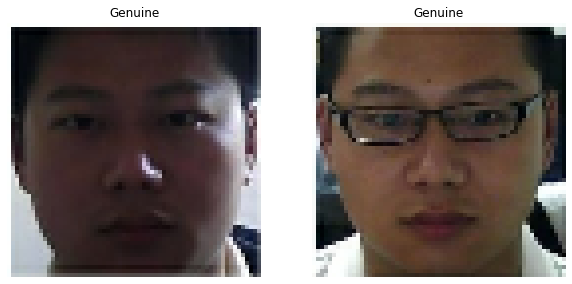

Difference Score =  0.0
Its a Genuine Face


In [330]:
predict_score()

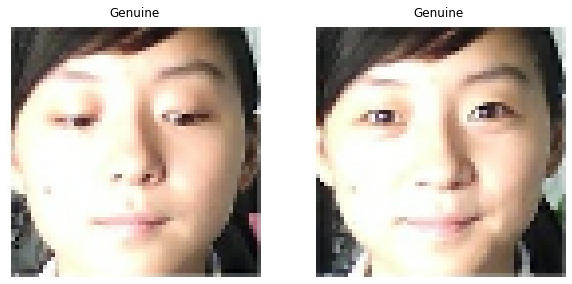

Difference Score =  0.0
Its a Genuine Face


In [331]:
predict_score()

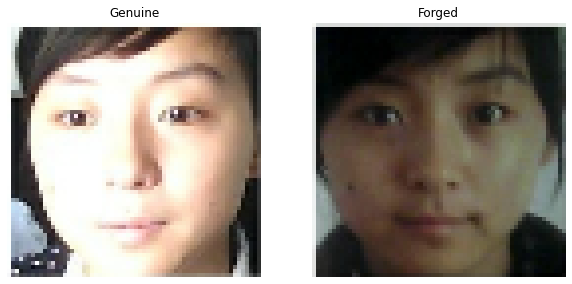

Difference Score =  1.9149882
Its a Forged Face


In [332]:
predict_score()